In [74]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg')
# print(data.loc[data.orthodox_proportion.isna()])
data.dropna(inplace=True)

<AxesSubplot:>

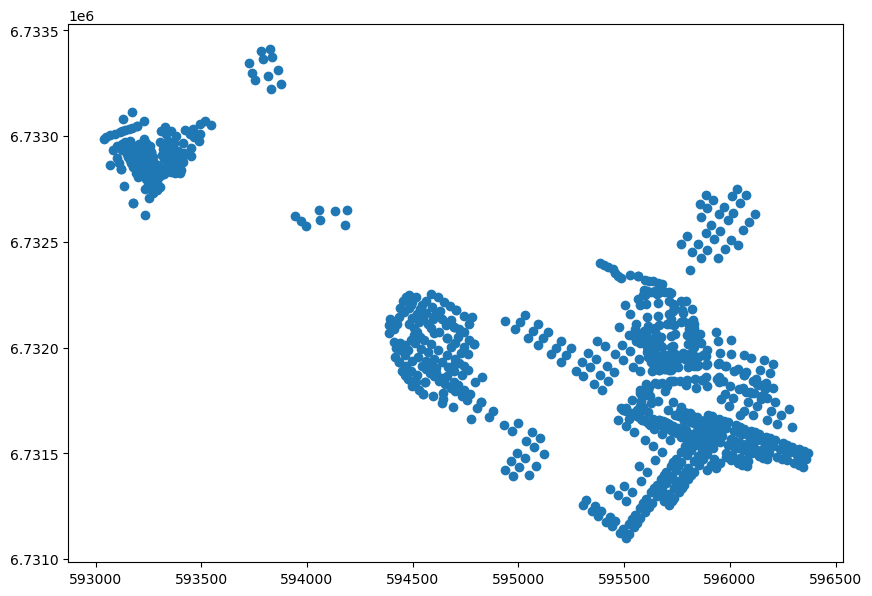

In [75]:
data.plot(figsize=(10,10))

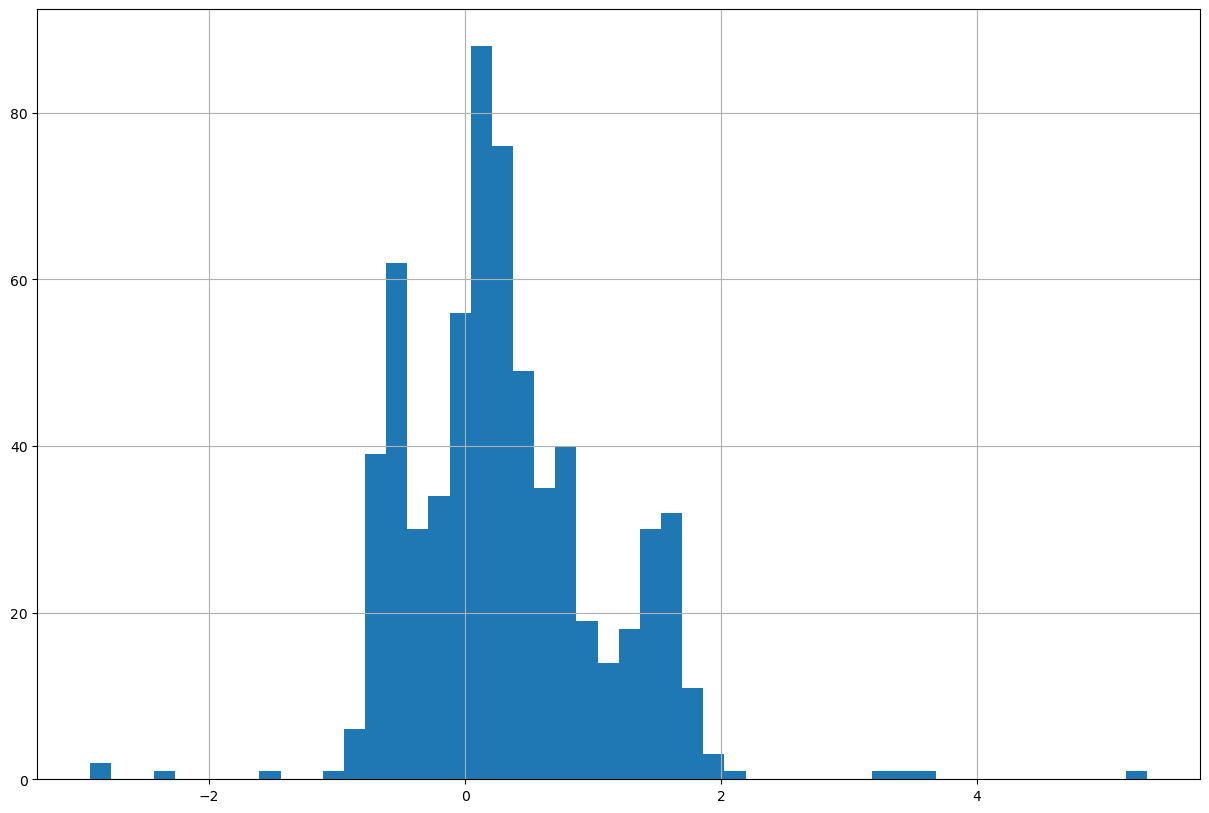

array([[<AxesSubplot:title={'center':'orthodox_proportion_ln'}>]],
      dtype=object)

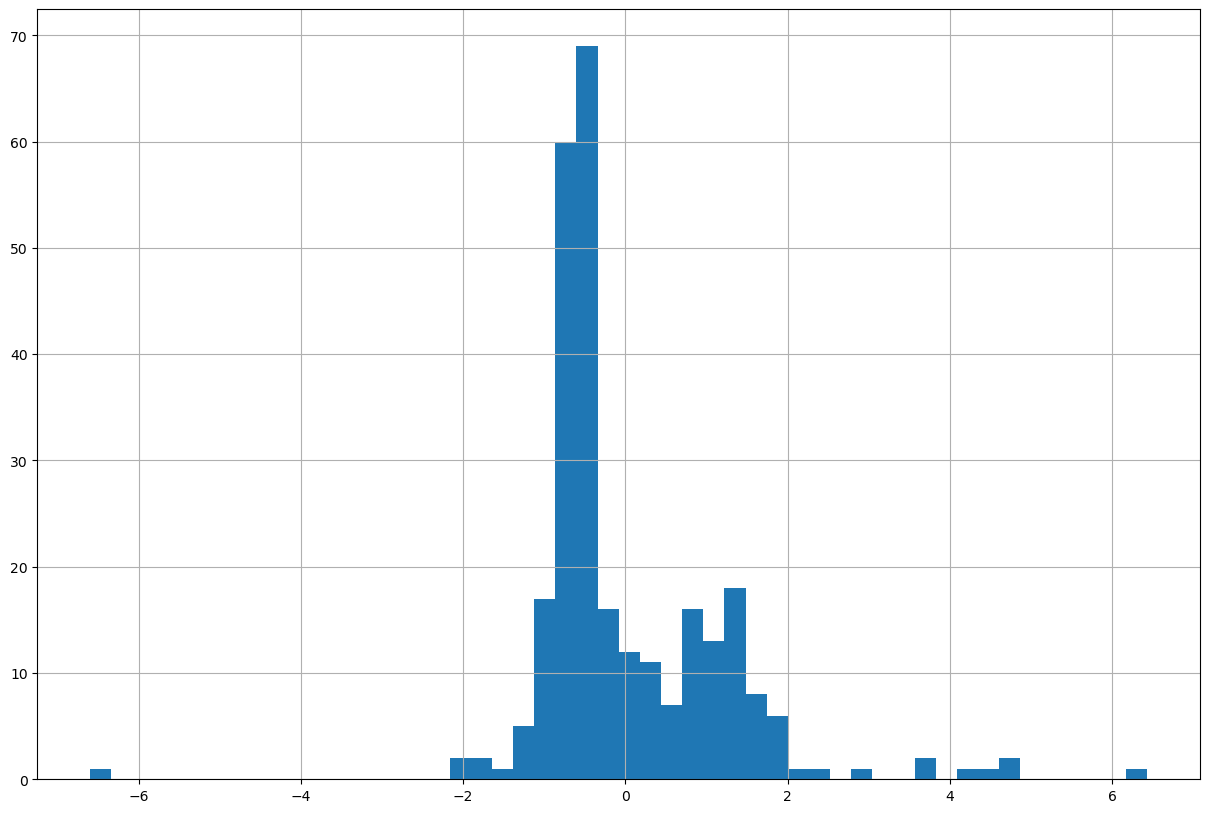

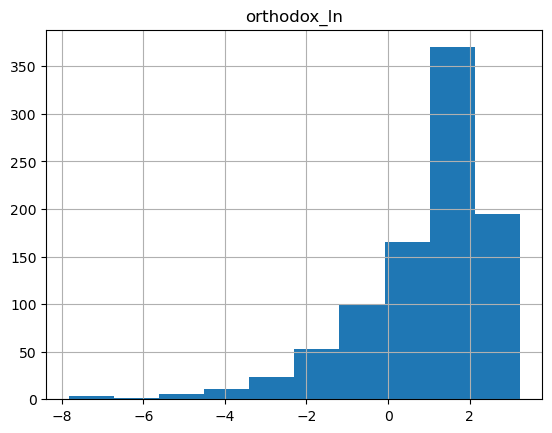

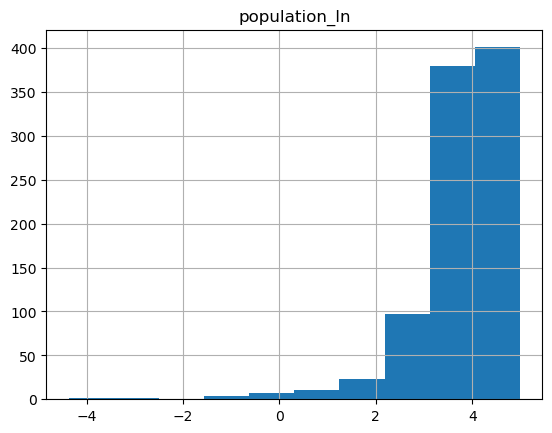

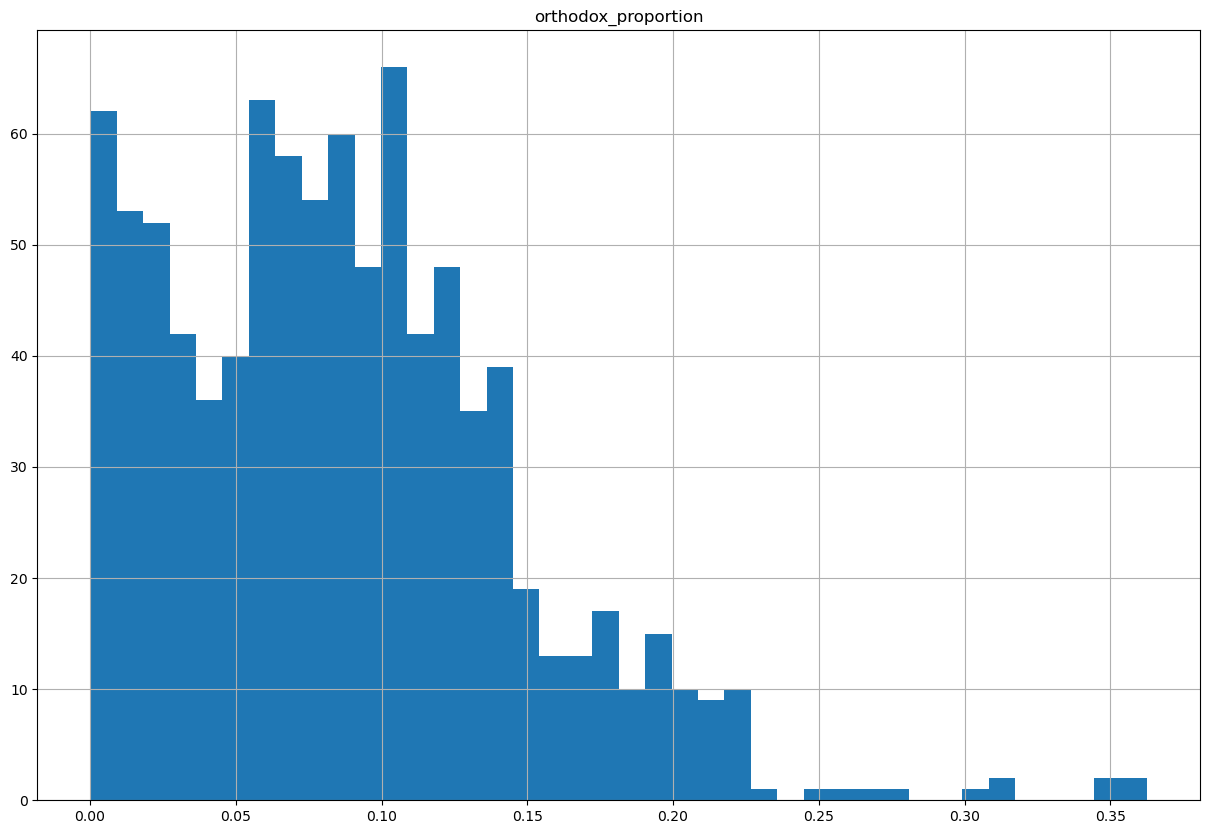

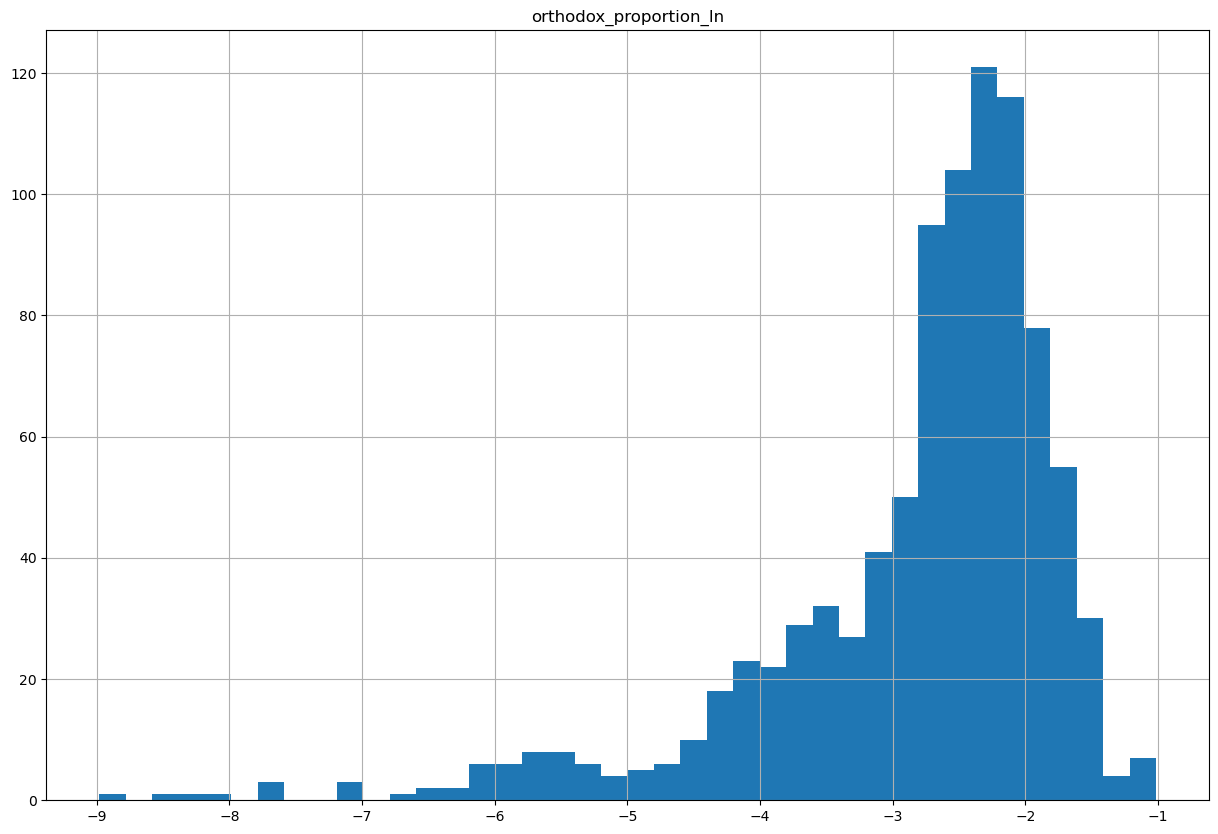

In [76]:
data.loc[data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
data.hist(column='orthodox_ln')
data.hist(column='population_ln')
data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
data.hist(column='orthodox_proportion_ln', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

In [77]:
# with pm.Model() as model_1:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O = np.array([0., 0., 0.])
#     mu_beta_L = np.array([0., 0., 0.])
#     sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
#     sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
#     beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O = pm.HalfNormal('sigma_O', 10)
#     sigma_L = pm.HalfNormal('sigma_L', 10)
#
#     O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
#     L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_1)

In [78]:
# with pm.Model() as model_2:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
#     mu_beta_P = np.array([0., 0., 0.])
#     sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
#     sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
#     beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
#     sigma_P = pm.HalfNormal('sigma_P', 50)
#     P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)
#
#     mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
#     O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_W, sigma_W, beta_O_prop, beta_P, sigma_O_prop, sigma_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



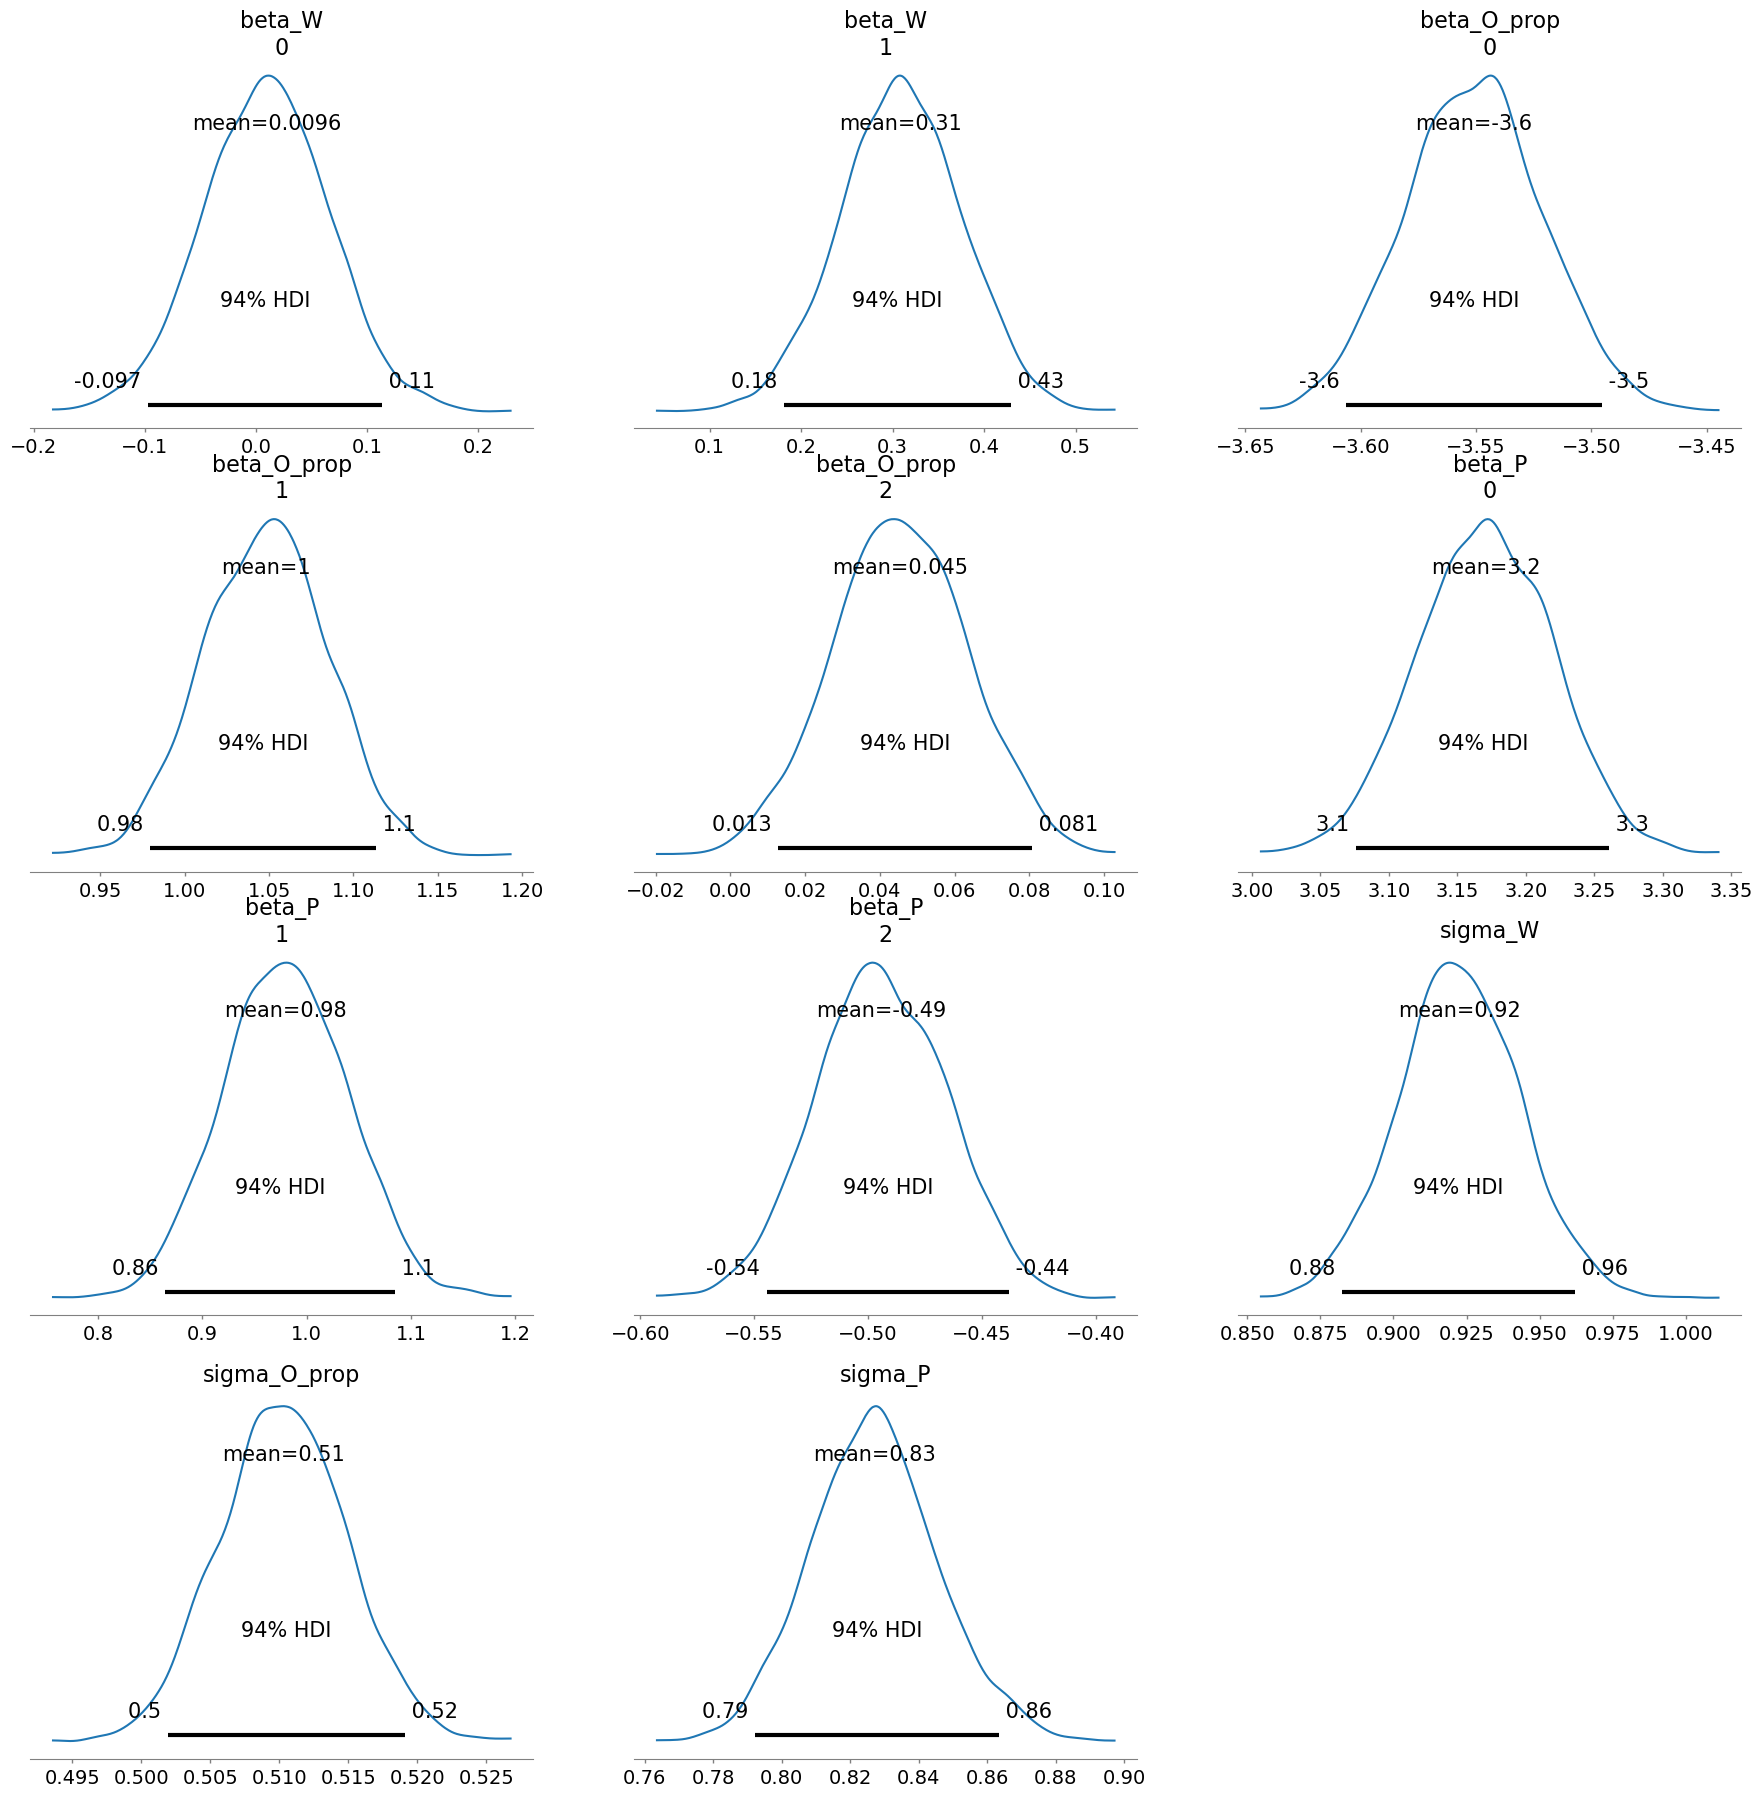

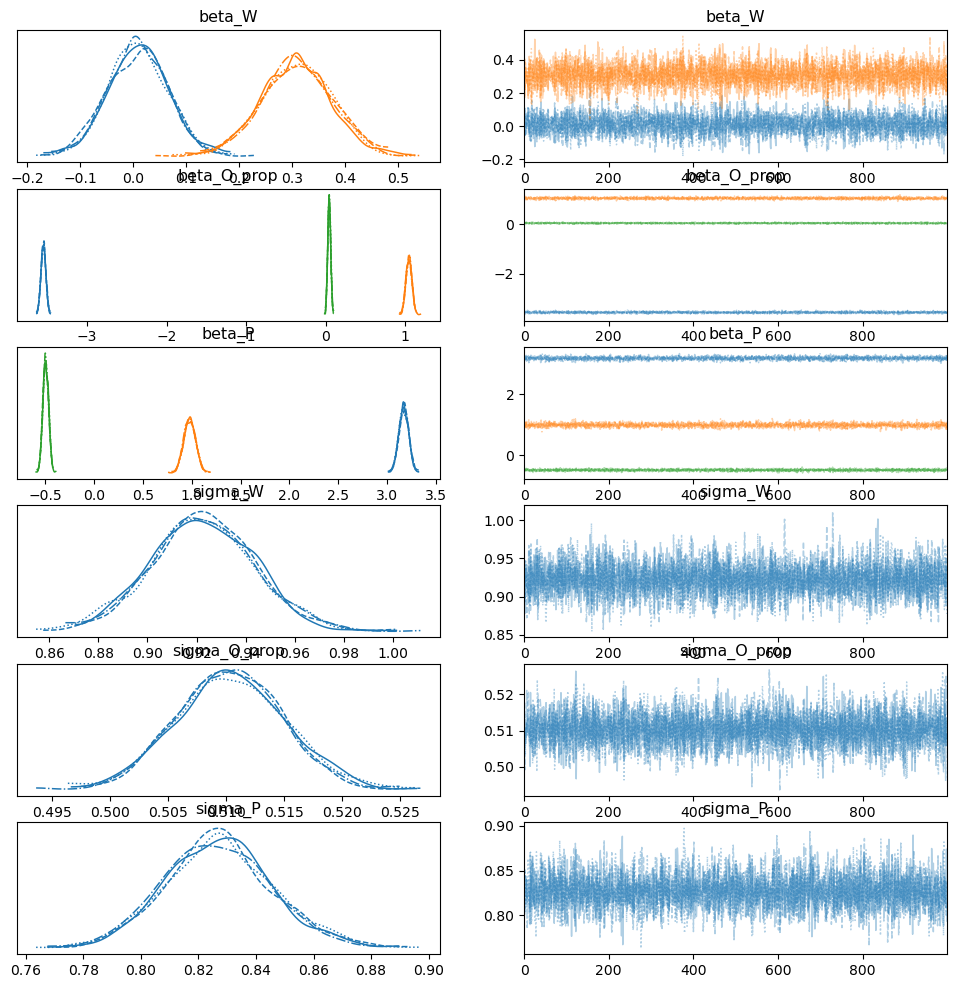

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



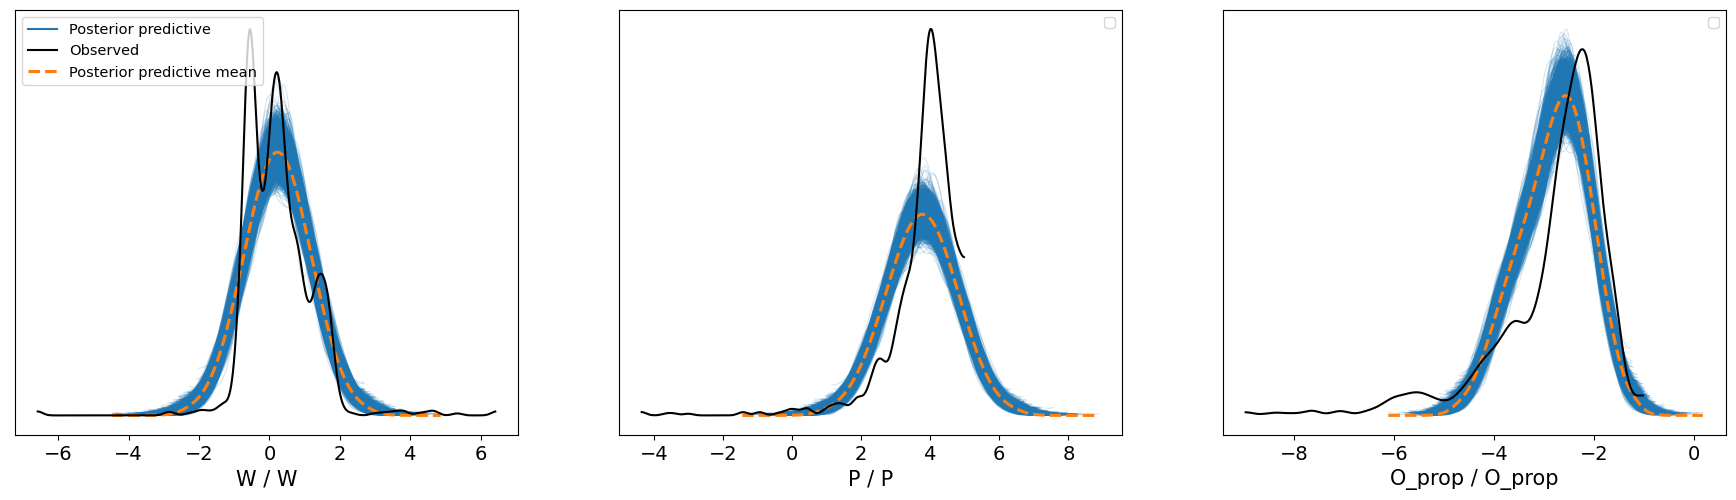

In [79]:
with pm.Model() as model_2:
    F = pm.MutableData('F', data.is_old.astype('int'))

    mu_beta_W = np.array([0, 0])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    W = pm.Normal('W', mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.income_per_capita_ln)

    mu_beta_O_prop = np.array([0, 0, 0])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))

    mu_beta_P = np.array([0., 0., 0.])
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
    beta_P = pm.MvNormal('beta_P', mu_beta_P, sigma_beta_P, shape=3)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.01)
    sigma_P = pm.HalfNormal('sigma_P', 1)

    P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * W, sigma_P, observed=data.population_ln)

    mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * W
    O_prop = pm.Normal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, observed=data.orthodox_proportion_ln)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_2)

az.plot_ppc(posterior_prediction)
az.plot_dist(prior)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O_prop, beta_P, sigma_O_prop, sigma_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

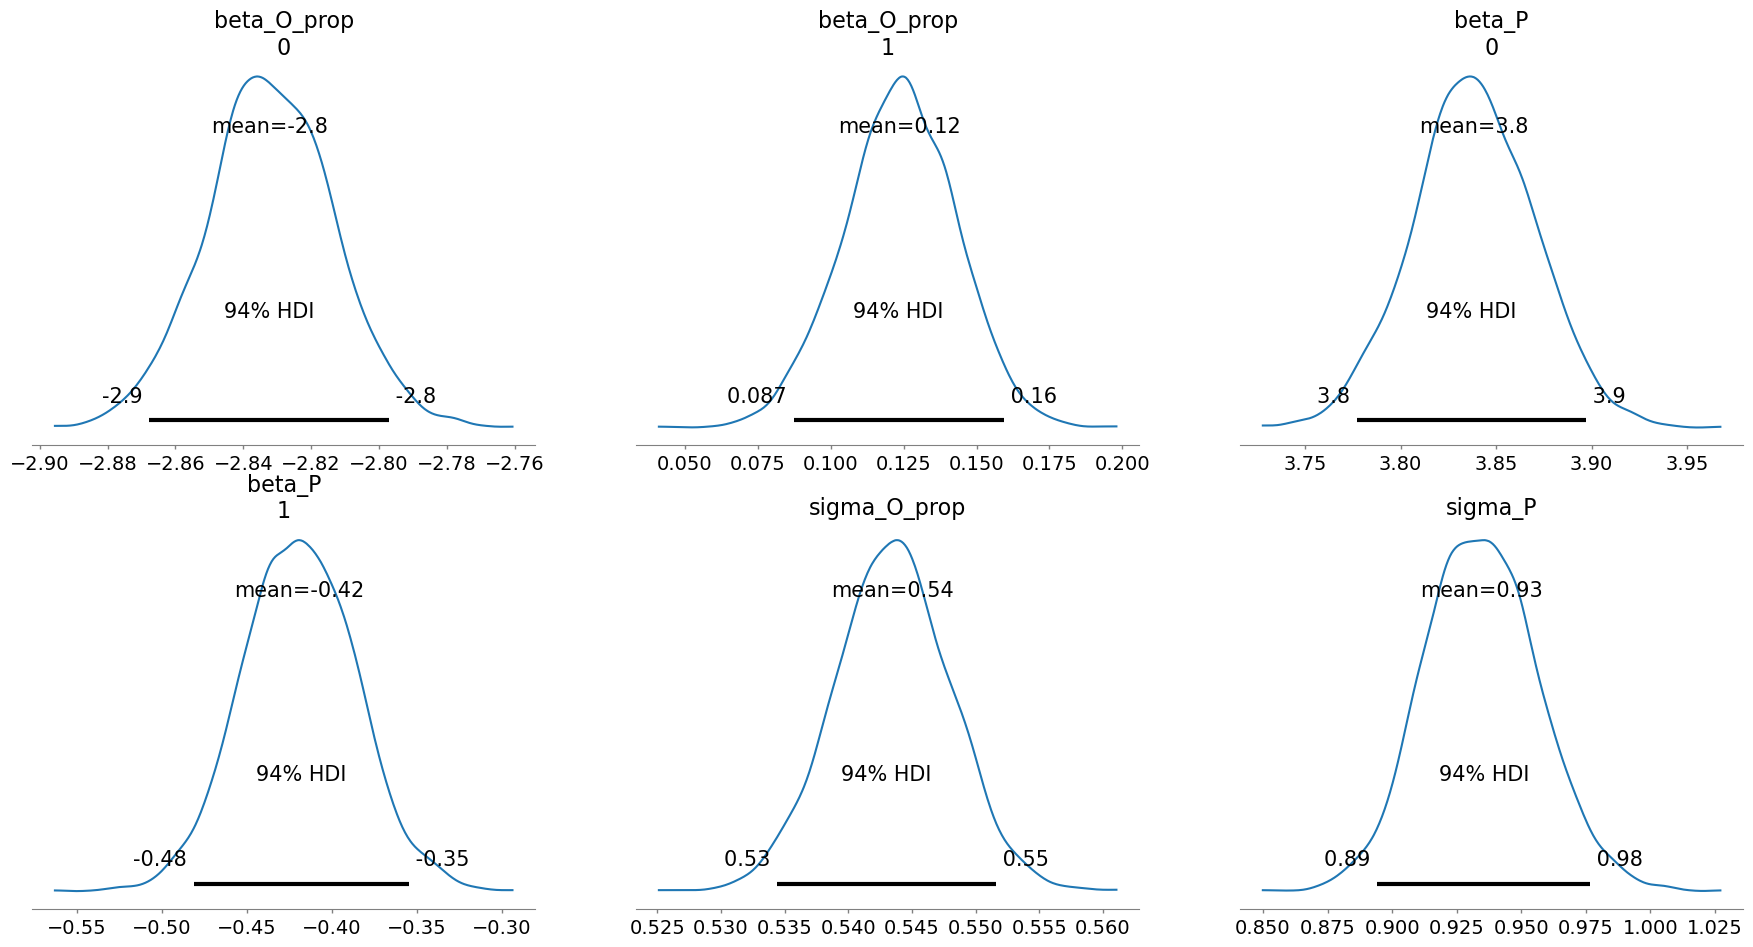

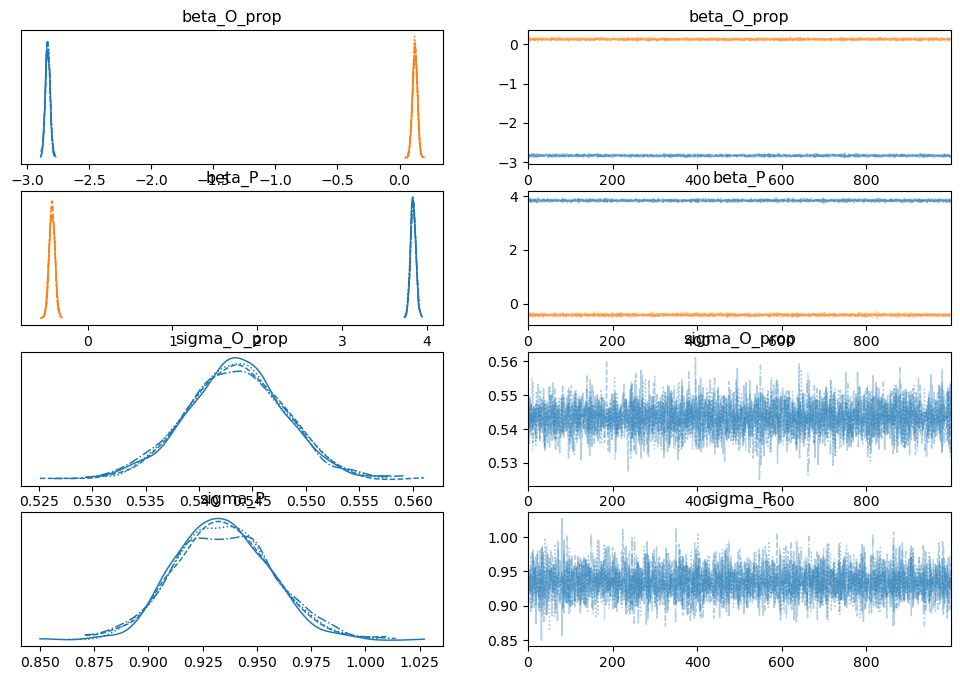

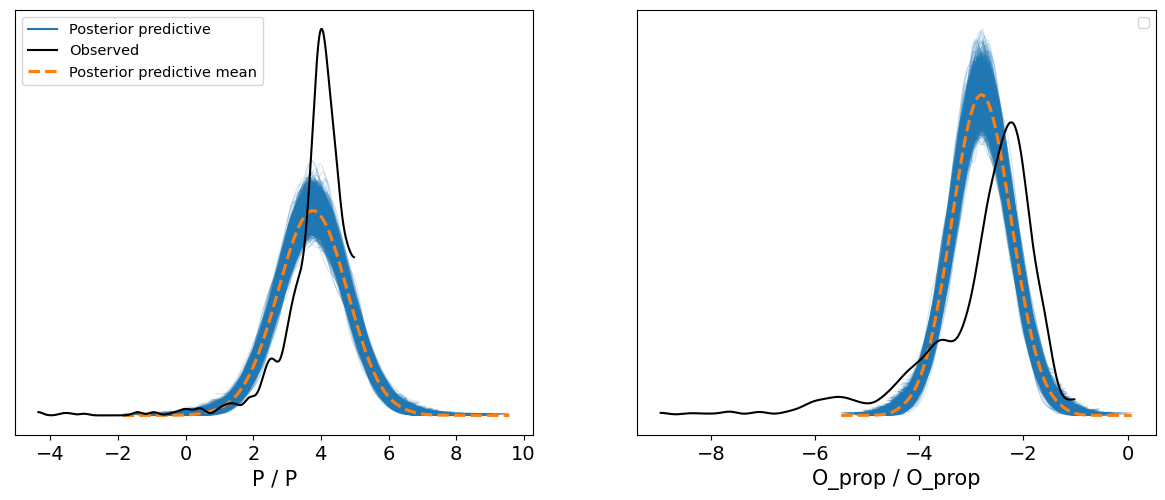

In [80]:
with pm.Model() as model_1:
    W = pm.MutableData('W', data.income_per_capita_ln)

    mu_beta_O_prop = np.array([0, 0])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1]))

    mu_beta_P = np.array([0., 0.])
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=2)
    beta_P = pm.MvNormal('beta_P', mu_beta_P, sigma_beta_P, shape=2)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.01)
    sigma_P = pm.HalfNormal('sigma_P', 1)

    P = pm.Normal('P', beta_P[0] + beta_P[1] * W, sigma_P, observed=data.population_ln)

    mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * W
    O_prop = pm.Normal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, observed=data.orthodox_proportion_ln)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_1)

az.plot_ppc(posterior_prediction)
az.plot_dist(prior)